# 2D_CNN_stroke_tia_binary

## Explainable Artificial Intelligence for MRI Images of Stroke Patients


### Master of Science in Egineering - Technical Specialization Project II
#### Autor: Loran Avci (avci@zhaw.ch)
#### Supervisors: Dr. Beate Sick (sick@zhaw.ch) , Dr. Helmut Grabner (grbn@zhaw.ch) 



In [8]:
! pip install opencv-python
! apt-get update ##[edited]
! apt-get install ffmpeg libsm6 libxext6  -y
! pip install statsmodels

     |████████████████████████████████| 49.9 MB 152 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 https://developer.download.nvid

## 00 SETUP 

+ Load libraries
+ Read Data

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
import h5py
import os
import pandas as pd
import random
from os.path import exists
import tensorflow as tf
print(os.getcwd())
print(tf.__version__)
tf.random.set_seed(2021)

/tf/notebooks/avci/XAI
2.2.0


In [2]:
# Create a folder for the output
output_folder = '/tf/notebooks/avci/XAI/stroke/noCV'
if not exists(output_folder):
    print("crated dir")
    os.makedirs(output_folder)
    os.makedirs(output_folder + "/checkpoints")

## 01 Read Data

In [3]:
# Read in the data from the hdf5 file
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File('/tf/notebooks/data/data_oct_18.h5', 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    # Image matrices
    X = h5["X"][:]
    # Image labels (1=stroke, 0=no-stroke)
    Y_img = h5["Y"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Path to images
    path = decode_data(h5["path"][:])
    # Image names/number
    img = decode_data(h5["img_id"][:])
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_img), len(Y_pat), len(pat), len(path), len(img))

H5-file:  ['X', 'Y', 'img_id', 'pat', 'path', 'stroke']
15214 15214 15214 15214 15214 15214


## 02 Pre-Processing 

In [4]:
# Get the functions that are used to remove the black images
def get_quantiles(X):
    q1=np.zeros([len(X),3])
    q99=np.zeros([len(X),3])
    for i in range(0,len(X)):
        q1[i]=[np.percentile(X[i,:,:,0],q=1,),np.percentile(X[i,:,:,1],q=1,),np.percentile(X[i,:,:,2],q=1,)]
        q99[i]=[np.percentile(X[i,:,:,0],q=99,),np.percentile(X[i,:,:,1],q=99,),np.percentile(X[i,:,:,2],q=99,)]
    return(q1, q99)

# Function to delete images by index
def delete_by_index(X, Y_img, Y_pat, pat, path, img, idx):
    X = np.delete(X, idx, axis=0) 
    Y_img = np.delete(Y_img, idx, axis=0)
    pat = np.delete(pat, idx, axis=0)
    path = np.delete(path, idx, axis=0)
    img = np.delete(img, idx, axis=0)
    Y_pat = np.delete(Y_pat, idx, axis=0)
    return(X, Y_img, Y_pat, pat, path, img)

In [5]:
print('Before: ', len(X), len(Y_img), len(Y_pat), len(pat), len(path), len(img))

# Get the 1st and 99th quantiles
q1, q99 = get_quantiles(X)

# If the 1st and 99th quantil are similar --> image is black
idx_black_img = np.where(q99[:,0]==q1[:,0])
X, Y_img, Y_pat, pat, path, img = delete_by_index(X, Y_img, Y_pat, pat, path, img, idx_black_img)
q1=np.delete(q1, idx_black_img, axis=0) 
q99=np.delete(q99, idx_black_img, axis=0) 


# If the 99th quantile is smaller 10 --> image is black
idx_black_img=np.where((q99[:,0]<10))
X, Y_img, Y_pat, pat, path, img = delete_by_index(X, Y_img, Y_pat, pat, path, img, idx_black_img)
q1=np.delete(q1, idx_black_img, axis=0) 
q99=np.delete(q99, idx_black_img, axis=0) 

print('After: ', len(X), len(Y_img), len(Y_pat), len(pat), len(path), len(img))

Before:  15214 15214 15214 15214 15214 15214
After:  15188 15188 15188 15188 15188 15188


13


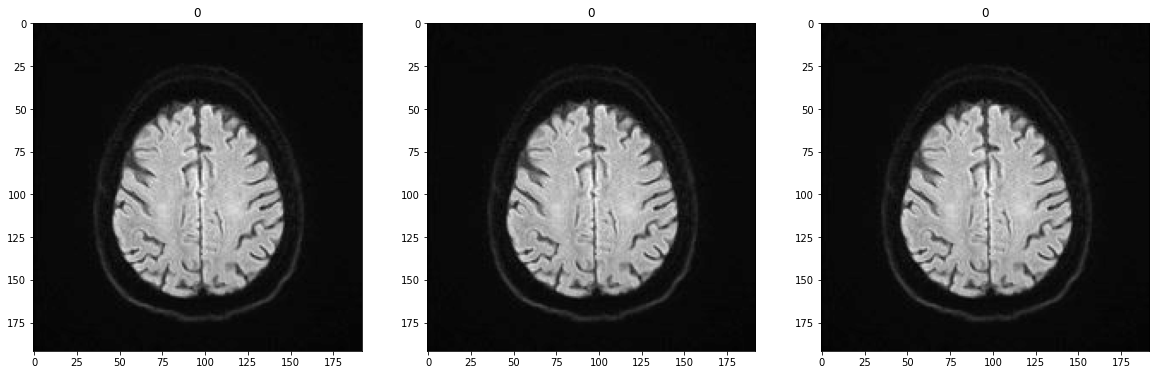

In [6]:
# check if the transformation worked --> plot has to show three successive images
j = 108
n_images = 3

print(pat[j])
plt.figure(figsize=(20,20))
for i in range(n_images):
    fig = plt.subplot(1,n_images,i+1)
    fig.imshow(X[j,:,:,i], cmap='gray')
    fig.set_title(Y_img[j])

### Normalize images
- For each image we substract it's mean and divide through it's standard deviation

min & max 32.0 255.0


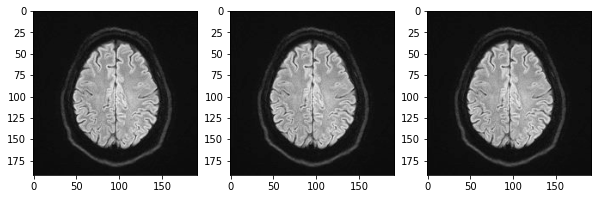

In [7]:
# unnormalized image
n_images = 3
plt.figure(figsize=(10,10))
j = 404
for i in range(n_images):
    fig = plt.subplot(1,n_images,i+1)
    fig.imshow(X[j,:,:,i], cmap = "gray")
print("min & max",np.min(X[1]), np.max(X[1]))

In [9]:
import cv2
def cropp_img(X, method = "global"):
    """
    crops an MRI image into size of visible brain area
    returns: list uf cropped images
    """
    cropped = []
    thl =[]
    for i in range(X[:,:,:,:].shape[0]):
        im = X[i,:,:,:]
        im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY).astype(np.uint8)
        th = np.quantile(im, q = 0.70)
        thl.append(th)
        if method == "global":
            _, thresh = cv2.threshold(im, th, 255, 0)
        elif method == "otsu":
            blur = cv2.GaussianBlur(im,(49,49),0)
            _,thresh = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        else:
            print('invalid method')
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        c = np.vstack(contours).reshape(-1,2)
        xmin = np.min(c[:,0])
        ymin = np.min(c[:,1])
        xmax = np.max(c[:,0])
        ymax = np.max(c[:,1])
        img = im[ymin:ymax, xmin:xmax]
        #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (192,192), interpolation = cv2.INTER_CUBIC)
        cropped.append(img)
    return(cropped,thl)

X_crop,thl = cropp_img(X, method = "global")


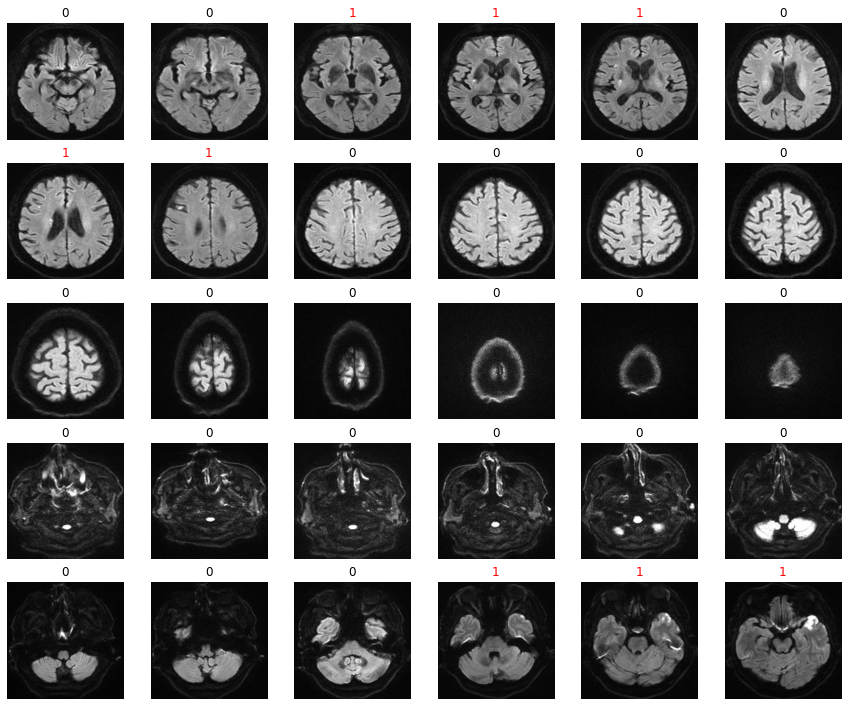

In [10]:
# cropped image
n_images = 30
plt.figure(figsize=(15,15))
j = 100
for i in range(n_images):
    fig = plt.subplot(6,6,i+1)
    fig.imshow(X_crop[j+i], cmap='gray')
    fig.axis('off')
    if Y_img[j+i] >0:
        fig.set_title(Y_img[j+i], c = "red")
    else: 
        fig.set_title(Y_img[j+i])        


In [11]:
X_crop_stack = np.stack( X_crop, axis=0 )
print(X_crop_stack.shape)

(15188, 192, 192)


Using TensorFlow backend.


-1.0 1.0
(15188, 192, 192)


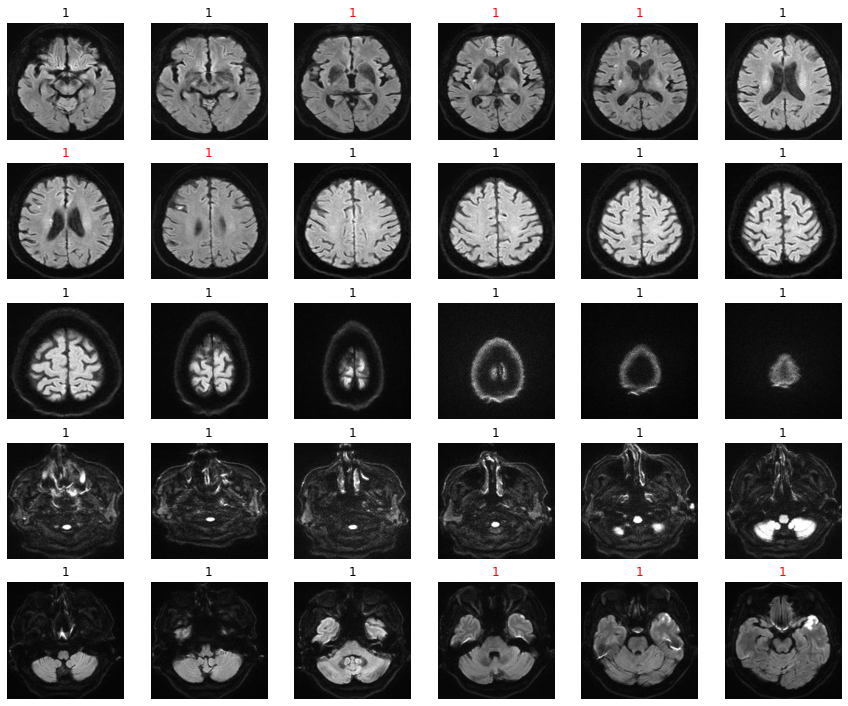

In [12]:
from keras.applications.vgg16 import preprocess_input
X_norm = X_crop_stack
X_norm = preprocess_input(X_crop_stack, mode='tf')
print(np.min(X_norm), np.max(X_norm))
print(X_norm.shape)
n_images = 30
plt.figure(figsize=(15,15))
j = 100
for i in range(n_images):
    fig = plt.subplot(6,6,i+1)
    fig.imshow(X_norm[j+i], cmap='gray')
    fig.axis('off')
    if Y_img[j+i] >0:
        fig.set_title(Y_img[j+i], c = "red")
    else: 
        fig.set_title(Y_pat[j+i])     

In [13]:
X_norm=X_norm.reshape((len(X_norm), 192, 192,1))
X = X_norm 
print(X.shape)

(15188, 192, 192, 1)


In [14]:
# consider stroke and no-stroke patients separately:
from sklearn.model_selection import train_test_split

# stroke patients
idx1 = np.where(Y_pat == 1)[0]
X1 = X[idx1]
Y1_pat = Y_pat[idx1]
Y1_img = Y_img[idx1]

# no stroke patients
idx0 = np.where(Y_pat == 0)[0]
X0 = X[idx0]
Y0_pat = Y_pat[idx0]
Y0_img = Y_img[idx0]


# train test split - Stroke patients:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, Y1_img, test_size=0.20, shuffle = True, random_state=2021)

# train val split - Stroke patients:
X1_train, X1_valid, y1_train, y1_valid = train_test_split(
    X1_train, y1_train, test_size=0.25, shuffle = True, random_state=2021)

print("Stroke patients: ")
print('train shapes: ', X1_train.shape , y1_train.shape)
print('validation shapes: ', X1_valid.shape , y1_valid.shape)
print('test shapes: ', X1_test.shape , y1_test.shape)


# train test split - Stroke patients:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X0, Y0_img, test_size=0.20, shuffle = True, random_state=2021)

# train val split - Stroke patients:
X0_train, X0_valid, y0_train, y0_valid = train_test_split(
    X0_train, y0_train, test_size=0.25, shuffle = True, random_state=2021)

print("\nControl: ")
print('train shapes: ', X0_train.shape , y0_train.shape)
print('validation shapes: ', X0_valid.shape , y0_valid.shape)
print('test shapes: ', X0_test.shape , y0_test.shape)

#concat train
X_train = np.concatenate([X1_train , X0_train], axis=0)
y_train = np.concatenate([y1_train , y0_train], axis=0)
#concat valid
X_valid = np.concatenate([X1_valid , X0_valid], axis=0)
y_valid = np.concatenate([y1_valid , y0_valid], axis=0)
# concat test
X_test = np.concatenate([X1_test , X0_test], axis=0)
y_test = np.concatenate([y1_test , y0_test], axis=0)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print('\n Merged shapes:')
print('train shapes: ', X_train.shape , y_train.shape)
print('validation shapes: ', X_valid.shape , y_valid.shape)
print('test shapes: ', X_test.shape , y_test.shape)



Stroke patients: 
train shapes:  (6318, 192, 192, 1) (6318,)
validation shapes:  (2107, 192, 192, 1) (2107,)
test shapes:  (2107, 192, 192, 1) (2107,)

Control: 
train shapes:  (2793, 192, 192, 1) (2793,)
validation shapes:  (931, 192, 192, 1) (931,)
test shapes:  (932, 192, 192, 1) (932,)

 Merged shapes:
train shapes:  (9111, 192, 192, 1) (9111, 2)
validation shapes:  (3038, 192, 192, 1) (3038, 2)
test shapes:  (3039, 192, 192, 1) (3039, 2)


### Define the CNN and the function for prediction

In [15]:
import pandas as pd
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import layers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda, Conv2D, MaxPool2D,AveragePooling2D,GlobalAveragePooling2D, Reshape, concatenate
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(2021)

In [17]:
# Initialize hyperparameters
input_shape = (X.shape[1], X.shape[2], X.shape[3]) #### shape channel 0
batch_size = 64
n_epochs = 200
print(input_shape)

(192, 192, 1)


In [19]:
#model_stroke = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-14 14:00:42.417988/checkpoints/97-0.19.hdf5')
#model_stroke.summary()

In [22]:
# gap model
#model = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-14 14:00:42.417988/checkpoints/96-0.21.hdf5')
#model = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-24 11:11:30.524477/checkpoints/190-0.16.hdf5')

# dense model
# model = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-21 07:59:07.883398/checkpoints/80-0.14.hdf5')

# shallow model
# model = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-21 12:17:02.721806/checkpoints/185-0.26.hdf5')

# flat model 
# model = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-21 16:29:40.056156/checkpoints/97-0.34.hdf5')

In [27]:
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

def bin_class_report(X_test,y_test, model):
    """
    modified classification report for binary output
    """
    NLL, Acc = model.evaluate( x=X_test, y=y_test, verbose=0)
    y_pred = model.predict(X_test.reshape(len(X_test), 192,192,1))
    
    # cm , AUC
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis =1))
    AUC =  metrics.roc_auc_score(y_test.argmax(axis=1), y_pred.argmax(axis =1))
    
    #acc
    nobs = sum(sum(cm))
    count = sum([cm[0,0], cm[1,1]])
    acc_ci_low, acc_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    #sens 
    sens = cm[1,1]/(cm[1,1]+cm[1,0])
    nobs = sum([cm[1,0],cm[1,1]])
    count = sum([cm[1,1]])
    sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    #spec 
    spec = cm[0,0]/(cm[0,1]+cm[0,0])
    nobs = sum([cm[0,1],cm[0,0]])
    count = sum([cm[0,0]])
    spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    print("\nPerformance on Test Set : ")
    print("\nAccuracy    [95% Conf.] :", np.around(Acc,4),np.around([acc_ci_low, acc_ci_upp],4))
    print("Sensitivity [95% Conf.] :", np.around(sens,4), np.around([sens_ci_low, sens_ci_upp],4))
    print("Specificity [95% Conf.] :", np.around(spec,4), np.around([spec_ci_low, spec_ci_upp],4))
    print("\nArea under Curve (AUC)  :", np.around(AUC,4))
    print("Negative Log-Likelihood :", np.around(NLL, 4))
    #print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis =1)))


model_path ='/tf/notebooks/avci/XAI/stroke/noCV/2021-05-21 16:29:40.056156/checkpoints/97-0.34.hdf5'
bin_class_report(X_test, 
                 y_test, 
                 model =keras.models.load_model(model_path))


Performance on Test Set : 

Accuracy    [95% Conf.] : 0.9269 [0.9171 0.9357]
Sensitivity [95% Conf.] : 0.6923 [0.6562 0.7262]
Specificity [95% Conf.] : 0.9924 [0.9881 0.9952]

Area under Curve (AUC)  : 0.8424
Negative Log-Likelihood : 0.3871


## CNN Model GAP

In [20]:
def model_gap(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and global average pooling
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 4
    model.add(Conv2D(256, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 5
    model.add(Conv2D(512, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Flat Part
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_gap(input_shape, drop_level = 0.3)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 192, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 192, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)       

In [21]:
def model_dense(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and dense layers
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 4
    model.add(Conv2D(256, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 5
    model.add(Conv2D(512, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Dense Part
    model.add(Flatten())
    model.add(Dense(256, kernel_initializer=initializers.he_normal(seed=3004)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(128, kernel_initializer=initializers.he_normal(seed=3004)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_dense(input_shape , drop_level = 0.3)
#model.summary()

In [22]:
def model_shallow(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and dense layers
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Flat Part
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_shallow(input_shape , drop_level = 0.3)
#model.summary()

In [23]:
def model_flat(input_shape, drop_level = 0.3):
    """
    moodel with 5 Con-blocks and global average pooling
    """
    # initialize Model
    model = Sequential()
    # Convolutional Block 1
    model.add(Conv2D(32, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same', input_shape = input_shape) )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 2
    model.add(Conv2D(64, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 3
    model.add(Conv2D(128, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 4
    model.add(Conv2D(256, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Convolutional Block 5
    model.add(Conv2D(512, (3,3), kernel_initializer=initializers.he_normal(seed=3004), padding='same') )
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate = drop_level))
    # Flat Part
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate = drop_level))
    model.add(Dense(2, kernel_initializer=initializers.he_normal(seed=3004), activation='softmax'))
    
    return model

#model = model_flat(input_shape, drop_level = 0.3)
#model.summary()

In [27]:
from datetime import datetime
train_model = False

# Initialize hyperparameters
input_shape = (X.shape[1], X.shape[2], X.shape[3]) #### shape channel 0
batch_size = 64
n_epochs = 100
print(input_shape)
if train_model:
    
    #### Train the model
    print('#### Training')
    # generate an output folder which contains the output of the current run
    print('Generate an output folder')
    output_folder_tmp = output_folder + r"/" + str(datetime.now())
    if not exists(output_folder_tmp):
        os.mkdir(output_folder_tmp)
        os.mkdir(output_folder_tmp + '/checkpoints')
        
    print(output_folder_tmp)
    # load the model
    print('# model loaded #')
    model = model
    
    print('# model compiled #')
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # Data augmentation
    print('# Data Augmentation #')
    datagen = ImageDataGenerator(width_shift_range=0.2, 
                                 height_shift_range=0.2, 
                                 rotation_range=20, 
                                 zoom_range=0.5, 
                                 shear_range=0.2,
                                 vertical_flip=True,
                                 horizontal_flip = True)
    
    datagen.fit(X_train, seed=3004)
    
    cp_callback = ModelCheckpoint(output_folder_tmp + '/checkpoints/{epoch:02d}-{val_loss:.2f}.hdf5', 
                                  monitor='val_loss', 
                                  verbose=1, 
                                  save_best_only=False, 
                                  save_weights_only=False, 
                                  mode='auto', 
                                  period=1)
    
    print('# Start training #')
    results = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size, shuffle = True), 
                                  steps_per_epoch=len(X_train)/batch_size, 
                                  epochs=n_epochs, 
                                  callbacks=[cp_callback],
                                  validation_data=(X_valid, y_valid))

# save model
model.save("cnn_gap_v2.h5")

# eval model
model.evaluate( x=X_test, y=y_test, verbose=1)

(192, 192, 1)
#### Training
Generate an output folder
/tf/notebooks/avci/XAI/stroke/noCV/2021-06-25 11:21:44.167913
# model loaded #
# model compiled #
# Data Augmentation #
# Start training #
Epoch 1/100
143/142 [==============================] - 24s 166ms/step - loss: 0.5073 - accuracy: 0.7934 - val_loss: 0.6158 - val_accuracy: 0.7637

Epoch 00001: saving model to /tf/notebooks/avci/XAI/stroke/noCV/2021-06-25 11:21:44.167913/checkpoints/01-0.62.hdf5
Epoch 2/100
143/142 [==============================] - 18s 124ms/step - loss: 0.4360 - accuracy: 0.8189 - val_loss: 0.4801 - val_accuracy: 0.8371

Epoch 00002: saving model to /tf/notebooks/avci/XAI/stroke/noCV/2021-06-25 11:21:44.167913/checkpoints/02-0.48.hdf5
Epoch 3/100
143/142 [==============================] - 18s 125ms/step - loss: 0.4097 - accuracy: 0.8335 - val_loss: 0.3981 - val_accuracy: 0.8535

Epoch 00003: saving model to /tf/notebooks/avci/XAI/stroke/noCV/2021-06-25 11:21:44.167913/checkpoints/03-0.40.hdf5
Epoch 4/100
143/14

In [35]:
val_loss = results.history["val_loss"]
val_acc = results.history["val_accuracy"]
train_loss = results.history["loss"]
train_acc = results.history["accuracy"]
df = pd.DataFrame.from_dict(results.history)

# Plot Predictions 

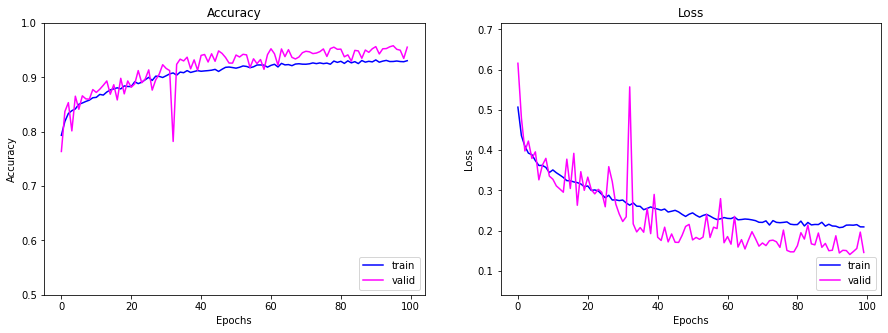

Max. validation accuracy:  0.9582
In epoch:  (array([95]),)
Min. validation loss:  0.141
In epoch:  (array([95]),)


In [36]:
def plot_res(df):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.plot(df['accuracy'], 'blue')
    plt.plot(df['val_accuracy'], 'magenta')
    plt.ylim(0.5, 1)
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc = 'lower right')
    plt.subplot(1,2,2)
    plt.plot(df['loss'], 'blue')
    plt.plot(df['val_loss'], 'magenta')
    plt.ylim(np.min([np.min(df['val_loss']), np.min(df['loss'])])-0.1, 
             np.max([np.max(df['val_loss']), np.max(df['loss'])])+0.1)
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc = 'lower right')
    plt.show();
    print("Max. validation accuracy: ", round(np.max(df['val_accuracy']),4))
    print('In epoch: ', np.where(df['val_accuracy']== np.max(df['val_accuracy'])))
    print("Min. validation loss: ", round(np.min(df['val_loss']),4))
    print('In epoch: ', np.where(df['val_loss'] == np.min(df['val_loss'])))

plot_res(df)

In [64]:
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

def bin_class_report(X_test,y_test, model):
    """
    modified classification report for binary output
    """
    NLL, Acc = model.evaluate( x=X_test, y=y_test, verbose=0)
    y_pred = model.predict(X_test.reshape(len(X_test), 192,192,1))
    
    # cm , AUC
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis =1))
    AUC =  metrics.roc_auc_score(y_test.argmax(axis=1), y_pred.argmax(axis =1))
    
    #acc
    nobs = sum(sum(cm))
    count = sum([cm[0,0], cm[1,1]])
    acc_ci_low, acc_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    #sens 
    sens = cm[1,1]/(cm[1,1]+cm[1,0])
    nobs = sum([cm[1,0],cm[1,1]])
    count = sum([cm[1,1]])
    sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    #spec 
    spec = cm[0,0]/(cm[0,1]+cm[0,0])
    nobs = sum([cm[0,1],cm[0,0]])
    count = sum([cm[0,0]])
    spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    print("\nPerformance on Test Set : ")
    print("\nAccuracy    [95% Conf.] :", np.around(Acc,4),np.around([acc_ci_low, acc_ci_upp],4))
    print("Sensitivity [95% Conf.] :", np.around(sens,4), np.around([sens_ci_low, sens_ci_upp],4))
    print("Specificity [95% Conf.] :", np.around(spec,4), np.around([spec_ci_low, spec_ci_upp],4))
    print("\nArea under Curve (AUC)  :", np.around(AUC,4))
    print("Negative Log-Likelihood :", np.around(NLL, 4))
 

In [65]:
bin_class_report(X_test, 
                 y_test, 
                 model = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-06-25 09:26:30.446906/checkpoints/88-0.14.hdf5'))


Performance on Test Set : 

Accuracy    [95% Conf.] : 0.9493 [0.9409 0.9566]
Sensitivity [95% Conf.] : 0.8205 [0.7895 0.8479]
Specificity [95% Conf.] : 0.9853 [0.9796 0.9894]

Area under Curve (AUC)  : 0.9029
Negative Log-Likelihood : 0.1722
